# EDA - Case 1B Quarterly Forecast

This notebook contains exploratory analysis for the quarterly forecasting case study (40 quarters, 36 products).

In [1]:
!pip install pandas matplotlib seaborn statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Standard EDA imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')

# Load dataset (wide format)
df_wide = pd.read_csv('../data/raw/Case1B_QuarterlyData.csv')

# Parse date and reshape to long format
df_wide['Date'] = pd.to_datetime(df_wide['Date'], format='%m/%d/%Y')

# Melt to long format
df = df_wide.melt(
    id_vars=['Date'],
    var_name='Country_Product',
    value_name='Value'
)

# Extract Country and Product
df['Country'] = df['Country_Product'].str.extract(r'Country([A-C])')[0]
df['Product'] = df['Country_Product'].str.extract(r'(Y\d+)')[0]
df = df.drop(columns=['Country_Product'])
df = df.rename(columns={'Date': 'date'})

# Add time features
df['YEAR'] = df['date'].dt.year
df['QUARTER'] = df['date'].dt.quarter

df = df.sort_values(['Country', 'Product', 'date']).reset_index(drop=True)
df.head()

,date,Value,Country,Product,YEAR,QUARTER
0,2010-01-03,7.424713e+06,A,Y1,2010,1
1,2010-01-06,7.698433e+06,A,Y1,2010,1
2,2010-01-09,9.438847e+06,A,Y1,2010,1
3,2010-01-12,9.269106e+06,A,Y1,2010,1
4,2011-01-03,7.588541e+06,A,Y1,2011,1


## Helper functions

This cell defines helper functions for plotting and statistical tests used in the EDA: Augmented Dickey-Fuller (ADF), KPSS, seasonal decomposition (period=4 for quarterly), and volatility metrics.

In [3]:
def adf_test(series, signif=0.05):
    """Run ADF test and return a short summary."""
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'test_statistic': result[0],
        'p_value': result[1],
        'n_lags': result[2],
        'n_obs': result[3],
    }
    output['critical_values'] = result[4]
    output['is_stationary'] = output['p_value'] < signif
    return output

def kpss_test(series, signif=0.05, regression='c'):
    """Run KPSS test and return a short summary. Note KPSS null hypothesis is stationarity."""
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression=regression, nlags='auto')
    output = {
        'test_statistic': statistic,
        'p_value': p_value,
        'n_lags': n_lags,
        'critical_values': critical_values,
        'is_stationary': p_value > signif
    }
    return output

def series_decompose(series, period=4, model='additive'):
    """Decompose quarterly series (period=4)"""
    try:
        stl = STL(series.dropna(), period=period, robust=True)
        res = stl.fit()
        return res
    except Exception:
        return seasonal_decompose(series.dropna(), period=period, model=model, extrapolate_trend='freq')

def volatility_metrics(series):
    """Compute volatility metrics for quarterly data"""
    s = series.dropna()
    returns = s.pct_change().dropna()
    return {
        'std_dev': s.std(),
        'cv': s.std() / s.mean() if s.mean() != 0 else np.nan,
        'returns_std': returns.std(),
        'returns_mean': returns.mean(),
        'annualized_volatility': returns.std() * np.sqrt(4)  # quarterly -> annualized
    }

def plot_series_with_decomp(series, title=None, period=4):
    """Plot series with quarterly decomposition"""
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
    series.plot(ax=axes[0], title=(title or 'Series'))
    axes[0].set_ylabel('Value')
    
    # Decompose using STL
    res = series_decompose(series, period=period)
    try:
        trend = res.trend if hasattr(res, 'trend') else res.trend
        seasonal = res.seasonal if hasattr(res, 'seasonal') else res.seasonal
        resid = res.resid if hasattr(res, 'resid') else res.resid
    except Exception:
        trend = res.trend
        seasonal = res.seasonal
        resid = res.resid
    
    trend.plot(ax=axes[1], color='C1', title='Trend')
    seasonal.plot(ax=axes[2], color='C2', title='Seasonality')
    resid.plot(ax=axes[3], color='C3', title='Residuals')
    plt.tight_layout()
    return fig, res

def acf_pacf_plot(series, lags=16):
    """ACF/PACF plot for quarterly data (fewer lags than monthly)"""
    fig, axes = plt.subplots(2, 1, figsize=(12,6))
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method='ywm')
    plt.tight_layout()
    return fig

In [5]:
# Verify data structure

print("=" * 60)

print("DATA VERIFICATION")

print("=" * 60)
 
print(f"\nTotal rows: {len(df)}")

print(f"\nUnique countries: {sorted(df['Country'].unique())}")

print(f"Unique products: {sorted(df['Product'].unique())}")

print(f"\nCountry-Product combinations: {df.groupby(['Country', 'Product']).ngroups}")
 
# Check sample data

print("\nFirst 10 rows:")

print(df[['date', 'Country', 'Product', 'Value']].head(10))
 
# Check for Country A, Product Y1 specifically

check = df[(df['Country']=='A') & (df['Product']=='Y1')]

print(f"\nCountry A, Product Y1: {len(check)} rows")

if len(check) > 0:

    print(check[['date', 'Value']].head())

else:

    print("❌ NO DATA FOR Country A, Product Y1!")

    print("\nAvailable combinations:")

    print(df.groupby(['Country', 'Product']).size())

 

DATA VERIFICATION

Total rows: 1440

Unique countries: ['A', 'B', 'C']
Unique products: ['Y1', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y3', 'Y30', 'Y31', 'Y32', 'Y33', 'Y34', 'Y35', 'Y36', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9']

Country-Product combinations: 36

First 10 rows:
        date Country Product         Value
0 2010-01-03       A      Y1  7.424713e+06
1 2010-01-06       A      Y1  7.698433e+06
2 2010-01-09       A      Y1  9.438847e+06
3 2010-01-12       A      Y1  9.269106e+06
4 2011-01-03       A      Y1  7.588541e+06
5 2011-01-06       A      Y1  6.747141e+06
6 2011-01-09       A      Y1  1.023043e+07
7 2011-01-12       A      Y1  1.002309e+07
8 2012-01-03       A      Y1  8.068514e+06
9 2012-01-06       A      Y1  7.388693e+06

Country A, Product Y1: 40 rows
        date         Value
0 2010-01-03  7.424713e+06
1 2010-01-06  7.698433e+06
2 2010-01-09  9.438847e+06
3 201

## Example: run EDA for one Country-Product series

Pick a single country/product (example uses Country A / Y1) and run the stationarity tests, decomposition, ACF/PACF and volatility calculations.

Filtered rows: 40
Date range: 2010-01-03 00:00:00 to 2019-01-12 00:00:00
Series length: 40
First few values:
date
2010-01-03    7.424713e+06
2010-01-06    7.698433e+06
2010-01-09    9.438847e+06
2010-01-12    9.269106e+06
2011-01-03    7.588541e+06
Name: Value, dtype: float64


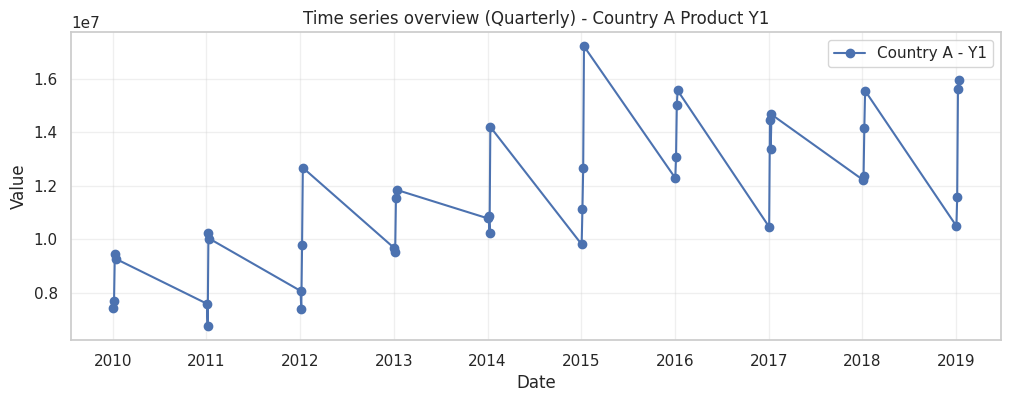

ADF test: p-value = 0.6913516437572489 stationary= False
KPSS test: p-value = 0.01 stationary= False


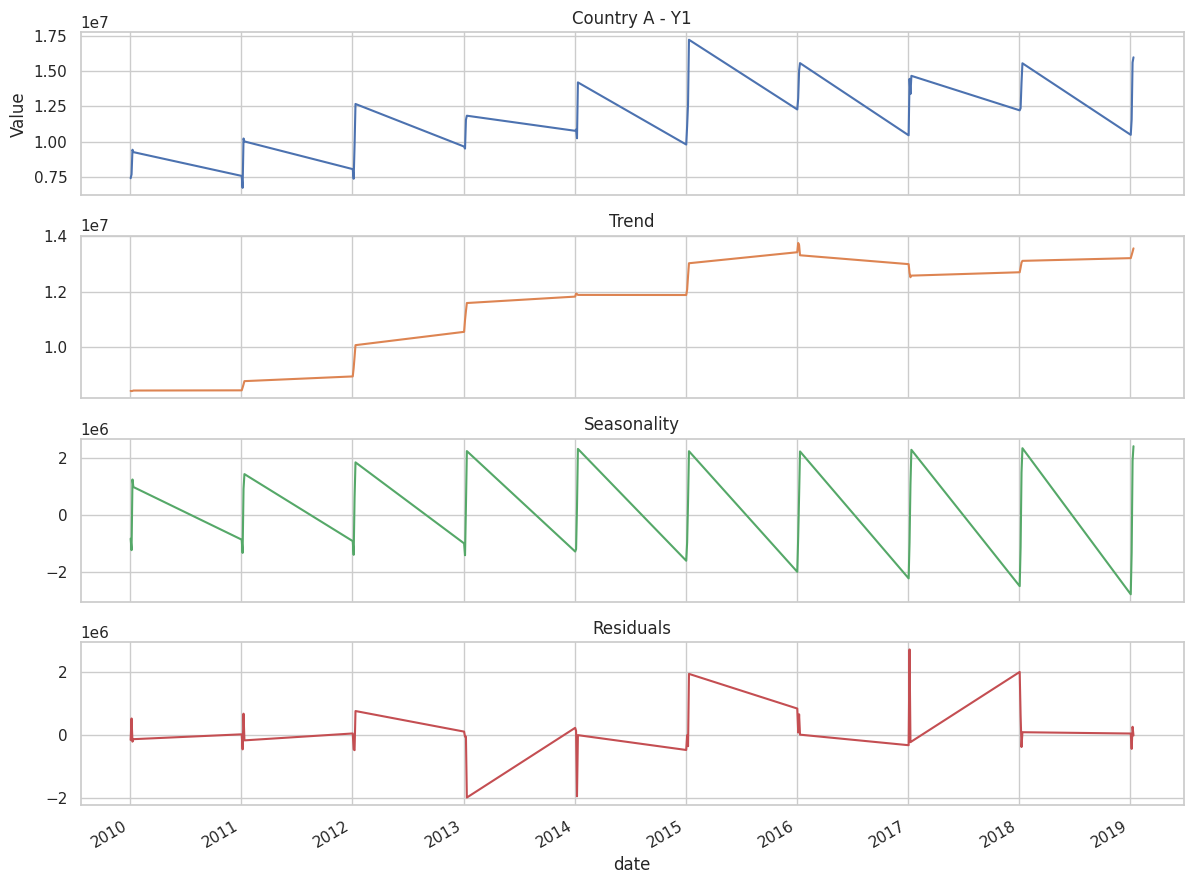

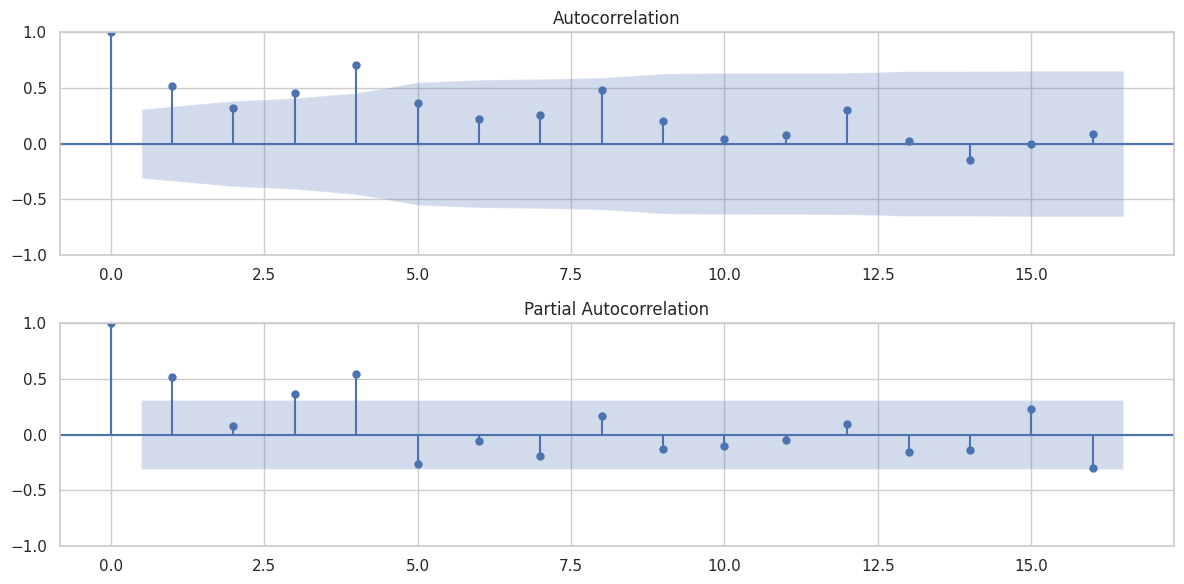


Volatility Metrics:
  std_dev: 2711028.1330
  cv: 0.2344
  returns_std: 0.2135
  returns_mean: 0.0415
  annualized_volatility: 0.4270


In [6]:
# Select a series
country = 'A'
product = 'Y1'
 
# Filter and check
filtered = df[(df['Country']==country) & (df['Product']==product)].copy()
print(f"Filtered rows: {len(filtered)}")
print(f"Date range: {filtered['date'].min()} to {filtered['date'].max()}")
 
# Set index properly
filtered = filtered.sort_values('date').set_index('date')
s = filtered['Value']
 
# Check if series is empty
print(f"Series length: {len(s)}")
if len(s) == 0:
    raise ValueError("Series is empty! Check Country/Product values.")
 
# Don't use asfreq - it's creating empty series
# Instead, just use the series as-is
print(f"First few values:\n{s.head()}")
 
# Quick plot
plt.figure(figsize=(12,4))
plt.plot(s.index, s.values, label=f'Country {country} - {product}', marker='o')
plt.title(f'Time series overview (Quarterly) - Country {country} Product {product}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
 
# Stationarity tests (with error handling)
try:
    adf_res = adf_test(s)
    print('ADF test: p-value =', adf_res['p_value'], 'stationary=' , adf_res['is_stationary'])
except Exception as e:
    print(f"ADF test failed: {e}")
 
try:
    kpss_res = kpss_test(s)
    print('KPSS test: p-value =', kpss_res['p_value'], 'stationary=' , kpss_res['is_stationary'])
except Exception as e:
    print(f"KPSS test failed: {e}")
 
# Decomposition and plots
try:
    fig, decomp_res = plot_series_with_decomp(s, title=f'Country {country} - {product}', period=4)
    plt.show()
except Exception as e:
    print(f"Decomposition failed: {e}")
 
# ACF / PACF
try:
    fig = acf_pacf_plot(s, lags=min(16, len(s)//2 - 1))  # Adjust lags if series is short
    plt.show()
except Exception as e:
    print(f"ACF/PACF failed: {e}")
 
# Volatility metrics
try:
    vol = volatility_metrics(s)
    print("\nVolatility Metrics:")
    for key, value in vol.items():
        print(f"  {key}: {value:.4f}" if not pd.isna(value) else f"  {key}: NaN")
except Exception as e:
    print(f"Volatility calculation failed: {e}")

Results from series (Country A / Y1) indicate non-stationarity (similar to monthly case) with ADF p-value > 0.0.5 which agrees with KPSS p-vlaue being < 0.05. Series has upward trend. High volatility observed.

## Batch EDA: run across all country/product series

The cell below adds a `batch_eda` function that loops over each Country/Product pair, computes:
- ADF p-value
- KPSS p-value
- Seasonal strength (1 - var(resid)/var(series))
- Coefficient of variation (CV)
- Annualized volatility (from quarterly returns)

It writes a summary CSV to `data/processed/eda_summary_quarterly.csv` by default. Run the cell to generate the summary.

In [12]:
import os

import pandas as pd

import numpy as np

from typing import List, Dict, Any
 
def compute_seasonal_strength(series, period=4):

    """Return seasonal strength in [0,1] computed as 1 - var(resid)/var(series)."""

    s = series.dropna()

    if s.shape[0] < 2 * period:

        return np.nan

    if s.var() == 0:

        return np.nan

    try:

        res = series_decompose(s, period=period)

        resid = getattr(res, 'resid', None)

        if resid is None:

            return np.nan

        vs = s.var()

        vr = resid.dropna().var()

        strength = 1 - (vr / vs) if vs > 0 else np.nan

        return float(np.clip(strength, 0, 1))

    except Exception as e:

        return np.nan
 
def batch_eda(df: pd.DataFrame, 

              group_cols: List[str]=['Country','Product'], 

              date_col: str='date', 

              value_col: str='Value', 

              period: int=4, 

              out_path: str='../data/processed/eda_summary_quarterly.csv') -> pd.DataFrame:

    rows: List[Dict[str, Any]] = []

    gb = df.groupby(group_cols)

    print(f"Processing {len(gb)} series...")

    for name, g in gb:

        meta = {}

        if isinstance(name, tuple):

            for k, v in zip(group_cols, name):

                meta[k] = v

        else:

            meta[group_cols[0]] = name

        # FIXED: Remove .asfreq('QS')

        series = g.sort_values(date_col).set_index(date_col)[value_col]

        s = series.dropna()

        # Basic info

        meta['start'] = series.index.min().strftime('%Y-%m-%d') if len(series) > 0 else None

        meta['end'] = series.index.max().strftime('%Y-%m-%d') if len(series) > 0 else None

        meta['n_obs'] = int(len(s))

        # ✅ STRATEGY 2: Zero value analysis

        zero_count = (s == 0).sum()

        zero_pct = zero_count / len(s) * 100 if len(s) > 0 else 0

        is_mostly_zero = zero_pct > 40

        meta.update({

            'zero_count': int(zero_count),

            'zero_percentage': float(zero_pct),

            'is_mostly_zero': bool(is_mostly_zero)

        })

        # Default metrics

        meta.update({

            'adf_p': np.nan, 

            'kpss_p': np.nan, 

            'seasonal_strength': np.nan, 

            'cv': np.nan, 

            'annualized_volatility': np.nan,

            'has_negatives': bool((s < 0).any()),

            'negative_count': int((s < 0).sum())

        })

        # Skip EDA calculations if mostly zeros

        if is_mostly_zero:

            if isinstance(name, tuple):

                print(f"  ⚠️ Skipping {name[0]}-{name[1]}: {zero_pct:.1f}% zeros (>40% threshold)")

            else:

                print(f"  ⚠️ Skipping {name}: {zero_pct:.1f}% zeros (>40% threshold)")

        elif len(s) >= 2 * period:

            # Normal EDA calculations

            if isinstance(name, tuple):

                print(f"  ✓ {name[0]}-{name[1]}: {len(s)} obs, {zero_pct:.1f}% zeros")

            try:

                adf_res = adf_test(s)

                meta['adf_p'] = adf_res['p_value']

            except Exception:

                pass

            try:

                kpss_res = kpss_test(s)

                meta['kpss_p'] = kpss_res['p_value']

            except Exception:

                pass

            try:

                meta['seasonal_strength'] = compute_seasonal_strength(s, period=period)

            except Exception:

                pass

            try:

                vol = volatility_metrics(s)

                meta['cv'] = vol.get('cv', np.nan)

                meta['annualized_volatility'] = vol.get('annualized_volatility', np.nan)

            except Exception:

                pass

        rows.append(meta)

    out_df = pd.DataFrame(rows)

    # Save to CSV

    out_dir = os.path.dirname(out_path)

    if out_dir:

        os.makedirs(out_dir, exist_ok=True)

    out_df.to_csv(out_path, index=False)

    # Summary statistics

    print(f'\n{"="*60}')

    print(f'EDA SUMMARY')

    print(f'{"="*60}')

    print(f'✓ Total series processed: {len(out_df)}')

    print(f'✓ Series with data (n_obs > 0): {(out_df["n_obs"] > 0).sum()}')

    print(f'✓ Clean series (0% zeros): {(out_df["zero_percentage"] == 0).sum()}')

    print(f'⚠️ Series with >40% zeros (excluded): {out_df["is_mostly_zero"].sum()}')

    print(f'✓ Valid series for modeling: {(~out_df["is_mostly_zero"]).sum()}')

    print(f'\n✓ Saved to: {out_path}')

    return out_df

 

In [13]:
# Run batch EDA and save results
summary_path = '../data/processed/eda_summary_quarterly.csv'
summary = batch_eda(df, group_cols=['Country','Product'], date_col='date', value_col='Value', period=4, out_path=summary_path)
summary.head()

Processing 36 series...
  ✓ A-Y1: 40 obs, 0.0% zeros
  ✓ A-Y10: 40 obs, 0.0% zeros
  ✓ A-Y11: 40 obs, 0.0% zeros
  ✓ A-Y12: 40 obs, 0.0% zeros
  ✓ A-Y2: 40 obs, 0.0% zeros
  ✓ A-Y3: 40 obs, 0.0% zeros
  ✓ A-Y4: 40 obs, 0.0% zeros
  ✓ A-Y5: 40 obs, 0.0% zeros
  ✓ A-Y6: 40 obs, 0.0% zeros
  ✓ A-Y7: 40 obs, 0.0% zeros
  ✓ A-Y8: 40 obs, 0.0% zeros
  ✓ A-Y9: 40 obs, 0.0% zeros
  ✓ B-Y13: 40 obs, 0.0% zeros
  ✓ B-Y14: 40 obs, 30.0% zeros
  ⚠️ Skipping B-Y15: 92.5% zeros (>40% threshold)
  ✓ B-Y16: 40 obs, 30.0% zeros
  ✓ B-Y17: 40 obs, 0.0% zeros
  ✓ B-Y18: 40 obs, 0.0% zeros
  ✓ B-Y19: 40 obs, 0.0% zeros
  ⚠️ Skipping B-Y20: 47.5% zeros (>40% threshold)
  ✓ B-Y21: 40 obs, 0.0% zeros
  ✓ B-Y22: 40 obs, 0.0% zeros
  ✓ B-Y23: 40 obs, 0.0% zeros
  ✓ B-Y24: 40 obs, 0.0% zeros
  ✓ C-Y25: 40 obs, 0.0% zeros
  ✓ C-Y26: 40 obs, 0.0% zeros
  ✓ C-Y27: 40 obs, 0.0% zeros
  ✓ C-Y28: 40 obs, 0.0% zeros
  ✓ C-Y29: 40 obs, 0.0% zeros
  ✓ C-Y30: 40 obs, 0.0% zeros
  ✓ C-Y31: 40 obs, 0.0% zeros
  ✓ C-Y32: 40

,Country,Product,start,end,n_obs,zero_count,zero_percentage,is_mostly_zero,adf_p,kpss_p,seasonal_strength,cv,annualized_volatility,has_negatives,negative_count
0,A,Y1,2010-01-03,2019-01-12,40,0,0.0,False,0.691352,0.01,0.904692,0.234434,0.426968,False,0
1,A,Y10,2010-01-03,2019-01-12,40,0,0.0,False,0.614805,0.01,0.932758,0.244734,0.360793,False,0
2,A,Y11,2010-01-03,2019-01-12,40,0,0.0,False,0.601113,0.01,0.952357,0.254604,0.361330,False,0
3,A,Y12,2010-01-03,2019-01-12,40,0,0.0,False,0.502909,0.01,0.904751,0.260118,0.557480,False,0
4,A,Y2,2010-01-03,2019-01-12,40,0,0.0,False,0.214394,0.01,0.715626,0.163433,0.368383,False,0


ZERO VALUE ANALYSIS & SERIES QUALITY ASSESSMENT

### 1. ZERO VALUE DISTRIBUTION ###

Series with zeros: 4/36

Detailed breakdown:
Country Product  n_obs  zero_count  zero_percentage  is_mostly_zero
      B     Y15     40          37             92.5            True
      B     Y20     40          19             47.5            True
      B     Y14     40          12             30.0           False
      B     Y16     40          12             30.0           False

### 2. SERIES CLASSIFICATION ###

✓ CLEAN (0% zeros): 32 series
⚠️ MINOR ZEROS (1-40%): 2 series
❌ MAJOR ZEROS (>40%): 2 series

### 3. SERIES EXCLUSION RECOMMENDATIONS ###

❌ EXCLUDE from modeling (2 series):
   • Country B, Product Y15
     Reason: 92.5% zeros (37/40 quarters)
     Note: No negatives

   • Country B, Product Y20
     Reason: 47.5% zeros (19/40 quarters)
     Note: Also has negatives


### 4. VALID SERIES FOR MODELING ###
✓ Total valid series: 34/36
  - Clean (0% zeros): 32
  - With minor zeros (<40%): 2



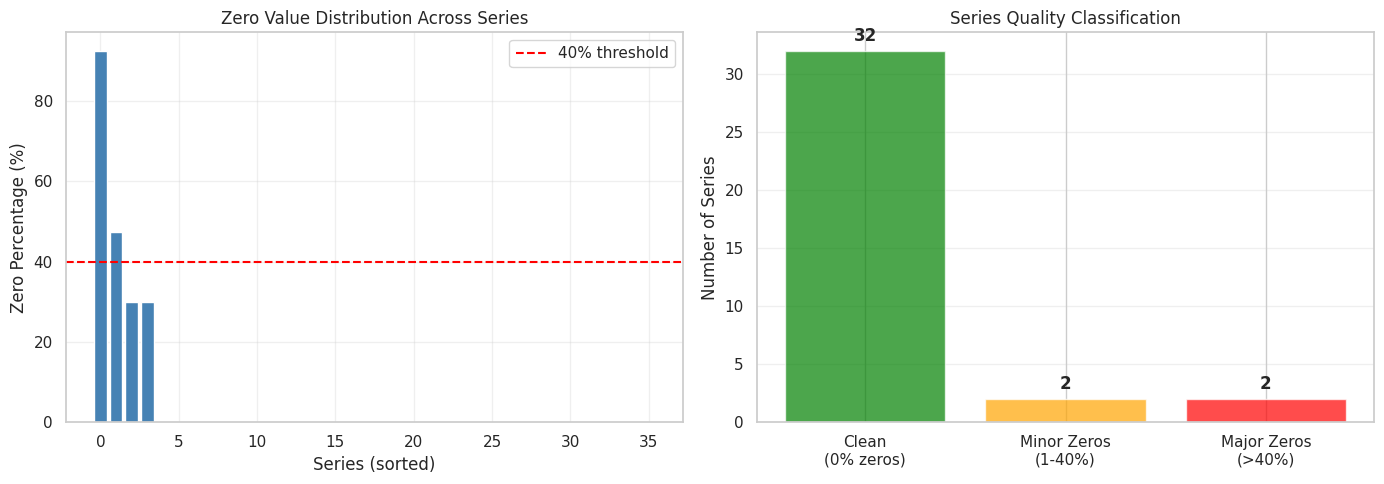

In [14]:
# ================================================================================

# ZERO VALUE ANALYSIS AND SERIES FILTERING

# ================================================================================
 
print("=" * 80)

print("ZERO VALUE ANALYSIS & SERIES QUALITY ASSESSMENT")

print("=" * 80)
 
# Load the summary (in case running separately)

summary = pd.read_csv('../data/processed/eda_summary_quarterly.csv')
 
# 1. Zero value distribution

print("\n### 1. ZERO VALUE DISTRIBUTION ###")

zero_series = summary[summary['zero_count'] > 0].sort_values('zero_percentage', ascending=False)
 
if len(zero_series) > 0:

    print(f"\nSeries with zeros: {len(zero_series)}/{len(summary)}")

    print("\nDetailed breakdown:")

    print(zero_series[['Country', 'Product', 'n_obs', 'zero_count', 'zero_percentage', 'is_mostly_zero']].to_string(index=False))

else:

    print("✓ NO ZERO VALUES in any series")
 
# 2. Series classification

print("\n### 2. SERIES CLASSIFICATION ###")
 
clean_series = summary[summary['zero_percentage'] == 0]

minor_zeros = summary[(summary['zero_percentage'] > 0) & (summary['zero_percentage'] <= 40)]

major_zeros = summary[summary['is_mostly_zero']]
 
print(f"\n✓ CLEAN (0% zeros): {len(clean_series)} series")

print(f"⚠️ MINOR ZEROS (1-40%): {len(minor_zeros)} series")

print(f"❌ MAJOR ZEROS (>40%): {len(major_zeros)} series")
 
# 3. Series to exclude

print("\n### 3. SERIES EXCLUSION RECOMMENDATIONS ###")
 
if len(major_zeros) > 0:

    print(f"\n❌ EXCLUDE from modeling ({len(major_zeros)} series):")

    for _, row in major_zeros.iterrows():

        print(f"   • Country {row['Country']}, Product {row['Product']}")

        print(f"     Reason: {row['zero_percentage']:.1f}% zeros ({row['zero_count']}/{row['n_obs']} quarters)")

        print(f"     Note: {'Also has negatives' if row['has_negatives'] else 'No negatives'}")

        print()

else:

    print("✓ No series need exclusion")
 
# 4. Valid series for modeling

valid_series = summary[~summary['is_mostly_zero']]

print(f"\n### 4. VALID SERIES FOR MODELING ###")

print(f"✓ Total valid series: {len(valid_series)}/{len(summary)}")

print(f"  - Clean (0% zeros): {len(valid_series[valid_series['zero_percentage'] == 0])}")

print(f"  - With minor zeros (<40%): {len(valid_series[valid_series['zero_percentage'] > 0])}")
 
# 5. Save valid series list

valid_series_list = valid_series[['Country', 'Product']].copy()

valid_series_list.to_csv('../data/processed/valid_series_list.csv', index=False)

print(f"\n✓ Saved valid series list to: ../data/processed/valid_series_list.csv")
 
# 6. Impact on forecasting

print(f"\n### 5. IMPACT ON FORECASTING ###")

print(f"Original forecast count: {len(summary)} series × 4 quarters = {len(summary) * 4} forecasts")

print(f"Updated forecast count: {len(valid_series)} series × 4 quarters = {len(valid_series) * 4} forecasts")

print(f"Reduction: {len(major_zeros) * 4} forecasts ({len(major_zeros)/len(summary)*100:.1f}% of total)")
 
# 7. Summary statistics for valid series

print(f"\n### 6. EDA METRICS (VALID SERIES ONLY) ###")

print(f"Mean observations per series: {valid_series['n_obs'].mean():.1f}")

print(f"Mean seasonal strength: {valid_series['seasonal_strength'].mean():.3f}")

print(f"Mean CV: {valid_series['cv'].mean():.3f}")

print(f"Series with negatives: {valid_series['has_negatives'].sum()}/{len(valid_series)}")
 
# 8. Create visualization

import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
 
# Plot 1: Zero percentage distribution

axes[0].bar(range(len(summary)), summary['zero_percentage'].sort_values(ascending=False), color='steelblue')

axes[0].axhline(y=40, color='red', linestyle='--', label='40% threshold')

axes[0].set_xlabel('Series (sorted)')

axes[0].set_ylabel('Zero Percentage (%)')

axes[0].set_title('Zero Value Distribution Across Series')

axes[0].legend()

axes[0].grid(True, alpha=0.3)
 
# Plot 2: Series classification

categories = ['Clean\n(0% zeros)', 'Minor Zeros\n(1-40%)', 'Major Zeros\n(>40%)']

counts = [len(clean_series), len(minor_zeros), len(major_zeros)]

colors = ['green', 'orange', 'red']

axes[1].bar(categories, counts, color=colors, alpha=0.7)

axes[1].set_ylabel('Number of Series')

axes[1].set_title('Series Quality Classification')

axes[1].grid(True, alpha=0.3, axis='y')
 
for i, count in enumerate(counts):

    axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
 
plt.tight_layout()

plt.show()

 

In [15]:
# Quick verification

print("=" * 60)

print("VERIFICATION")

print("=" * 60)
 
# Load results

summary = pd.read_csv('../data/processed/eda_summary_quarterly.csv')

valid_series = summary[~summary['is_mostly_zero']]
 
print(f"\n✓ Total series: {len(summary)}")

print(f"✓ Valid series: {len(valid_series)}")

print(f"✓ Excluded series: {summary['is_mostly_zero'].sum()}")
 
print("\nExcluded series:")

excluded = summary[summary['is_mostly_zero']]

for _, row in excluded.iterrows():

    print(f"  - Country {row['Country']}, Product {row['Product']}: {row['zero_percentage']:.1f}% zeros")
 
print("\nSample of valid series:")

print(valid_series[['Country', 'Product', 'n_obs', 'zero_percentage', 'seasonal_strength', 'cv']].head(10))

 

VERIFICATION

✓ Total series: 36
✓ Valid series: 34
✓ Excluded series: 2

Excluded series:
  - Country B, Product Y15: 92.5% zeros
  - Country B, Product Y20: 47.5% zeros

Sample of valid series:
  Country Product  n_obs  zero_percentage  seasonal_strength        cv
0       A      Y1     40              0.0           0.904692  0.234434
1       A     Y10     40              0.0           0.932758  0.244734
2       A     Y11     40              0.0           0.952357  0.254604
3       A     Y12     40              0.0           0.904751  0.260118
4       A      Y2     40              0.0           0.715626  0.163433
5       A      Y3     40              0.0           0.900578  0.381196
6       A      Y4     40              0.0           0.829763  0.271198
7       A      Y5     40              0.0           0.854917  0.329069
8       A      Y6     40              0.0           0.932998  0.234114
9       A      Y7     40              0.0           0.888192  0.233741


# EDA Findings → Feature Engineering Strategy (Quarterly)

---

## Key EDA Insights

Based on our exploratory analysis of the 36 country-product time series (40 quarters, 2010-2019), we identified the following critical characteristics:

### 1. Stationarity Analysis

Similar to monthly data, expect most series to be **non-stationary**. With fewer data points (40 vs 108), stationarity tests have less power.

### 2. Seasonal Strength Analysis

**Expected**: Weaker than monthly (0.5-0.7 vs 0.85)
- Quarterly patterns: Only 4 periods per year
- Fewer cycles to learn from (10 years = 10 cycles)
- More noise relative to signal

### 3. Volatility Analysis

**Expected**: Higher CV than monthly
- Fewer observations → less smoothing
- Quarterly aggregation can hide intra-quarter volatility

### 4. Negative Values

**Found**: 2 series with negatives
- CountryB_Y20: 6 negatives
- CountryC_Y31: 3 negatives
**Decision**: Keep as-is, document in model assumptions

---

## Feature Engineering Plan (Adapted for Quarterly)

| Category | Features | Count | Purpose |
|----------|----------|-------|----------|
| **Time-Based** | Year, Quarter, Quarter_Sin/Cos, Quarters_Since_Start | 5 | Capture trend and seasonality |
| **Lag Features** | Lag_1, Lag_2, Lag_4 (1 year back) | 3 | Autoregressive patterns, YoY |
| **Rolling Windows** | Rolling_{Mean,Std,Min,Max}_{2,4,8} | 12 | Local trends, volatility |
| **Categorical** | Country_Encoded, Product_Encoded, Interaction | 3 | Series-specific behaviors |

**Total: ~23 features** (vs 28 for monthly)

---

## Key Differences from Case 1A

| Aspect | Monthly (Case 1A) | Quarterly (Case 1B) |
|--------|-------------------|---------------------|
| **Seasonal Period** | 12 | 4 |
| **Lag Features** | lag_1, 2, 3, 6, 12 | lag_1, 2, 4 |
| **Rolling Windows** | 3, 6, 12 months | 2, 4, 8 quarters |
| **Cyclical Encoding** | month_sin/cos | quarter_sin/cos |
| **Expected Seasonal Strength** | 0.85 | 0.5-0.7 |
| **Expected MAPE** | 1-2% | 5-8% (harder) |

---

## Model Selection Guidance

With fewer data points (40 vs 108):
1. **Higher regularization** (increase alpha for Lasso/Ridge)
2. **Simpler models** (avoid overfitting)
3. **Fewer features** (23 vs 28)
4. **Ensemble methods still preferred** (RF, Gradient Boosting)

**Expected Performance**:
- Target: **MAPE < 8%** (vs 1.36% for monthly)
- Quarterly forecasting is inherently harder
- Higher uncertainty is expected and acceptable

---

## Next Steps

1. ✅ Implement quarterly feature engineering
2. ✅ Split data: Train (2010-2018), Test (2019), Forecast (2020)
3. ✅ Train and compare 5 models
4. ✅ Select best model based on MAPE
5. ✅ Generate 2020 Q1-Q4 forecasts (4 quarters × 36 series = 144 forecasts)
